<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Данные" data-toc-modified-id="Данные-0.1"><span class="toc-item-num">0.1&nbsp;&nbsp;</span>Данные</a></span></li><li><span><a href="#Наименование-признаков" data-toc-modified-id="Наименование-признаков-0.2"><span class="toc-item-num">0.2&nbsp;&nbsp;</span>Наименование признаков</a></span></li><li><span><a href="#Формулы" data-toc-modified-id="Формулы-0.3"><span class="toc-item-num">0.3&nbsp;&nbsp;</span>Формулы</a></span></li></ul></li><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Анализ-данных" data-toc-modified-id="Анализ-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ данных</a></span></li><li><span><a href="#Модель" data-toc-modified-id="Модель-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Модель</a></span></li><li><span><a href="#Чек-лист-готовности-проекта" data-toc-modified-id="Чек-лист-готовности-проекта-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист готовности проекта</a></span></li></ul></div>

# Восстановление золота из руды

Подготовьте прототип модели машинного обучения для «Цифры». Компания разрабатывает решения для эффективной работы промышленных предприятий.

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. Используйте данные с параметрами добычи и очистки. 

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

Вам нужно:

1. Подготовить данные;
2. Провести исследовательский анализ данных;
3. Построить и обучить модель.

Чтобы выполнить проект, обращайтесь к библиотекам *pandas*, *matplotlib* и *sklearn.* Вам поможет их документация.

<b>Задача: подготовить прототип модели машинного обучения, которая должна предсказать коэффициент восстановления золота из золотосодержащей руды. </b>

### Данные
В нашем распоряжении имеются данные с параметрами добычи и очистки. 

Данные находятся в трёх файлах:
- **gold_recovery_train.csv** — обучающая выборка;
- **gold_recovery_test.csv** — тестовая выборка;
- **gold_recovery_full.csv** — исходные данные.

Данные индексируются датой и временем получения информации (признак date). Соседние по времени параметры часто похожи.
Некоторые параметры недоступны, потому что замеряются и/или рассчитываются значительно позже. Из-за этого в тестовой выборке отсутствуют некоторые признаки, которые могут быть в обучающей. Также в тестовом наборе нет целевых признаков.<br/>
Исходный датасет содержит обучающую и тестовую выборки со всеми признаками.<br/>

Данные в нашем распоряжении являются сырыми: их просто выгрузили из хранилища. Прежде чем приступить к построению модели, требуется проверить их на корректность согласно согласованной с заказчиком инструкции.

### Наименование признаков
Наименование признаков строится по следующему правилу:

`[этап].[тип_параметра].[название_параметра]`
    

Пример: `rougher.input.feed_ag`

Возможные значения для блока `[этап]`:
- **rougher** — флотация
- **primary_cleaner** — первичная очистка
- **secondary_cleaner** — вторичная очистка
- **final** — финальные характеристики

Возможные значения для блока `[тип_параметра]`:
- **input** — параметры сырья
- **output** — параметры продукта
- **state** — параметры, характеризующие текущее состояние этапа
- **calculation** — расчётные характеристики

### Формулы
Требуется использовать следующие формулы для вычисления метрик качества.

Эффективность обогащения рассчитывается по формуле:

$$
Recovery = {{C \times (F - T)} \over {F \times (C - T)}} \times 100\%
$$

где:
- $C$ — доля золота в концентрате после флотации/очистки;
- $F$ — доля золота в сырье/концентрате до флотации/очистки;
- $T$ — доля золота в отвальных хвостах после флотации/очистки.

Для решения задачи введём новую метрику качества — **sMAPE** (Symmetric Mean Absolute Percentage Error - симметричное среднее абсолютное процентное отклонение).
Она похожа на MAE, но выражается не в абсолютных величинах, а в относительных и одинаково учитывает масштаб и целевого признака, и предсказания.

Метрика sMAPE вычисляется так:

$$
sMAPE = {1 \over N} \sum\limits_{i=1}^N {{|y_i - y'_i|} \over {(|y_i| + |y'_i|) / 2}} \times 100\%
$$

При работе над проектом требуется спрогнозировать сразу две величины эффективности обогащения:
- эффективность обогащения чернового концентрата `rougher.output.recovery`;
- эффективность обогащения финального концентрата `final.output.recovery`.

Итоговая метрика sMAPE складывается из двух величин:

$$
Final\_sMAPE = 25\% \times sMAPE(rougher) + 75\% \times sMAPE(final)
$$

## Подготовка данных

Сначала отдельно импортируем все необходимые библиотеки и функции:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor

from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score, make_scorer
from sklearn.metrics import f1_score, roc_curve, roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler

from tqdm.notebook import tqdm

Далее откроем и изучим файлы с данными:

In [2]:
df_train = pd.read_csv('/datasets/gold_recovery_train_new.csv')
print('\033[1mTRAIN:\033[0m')
df_train.info()
display(df_train.head())
print('----------------------------------------------')
print()
df_test = pd.read_csv('/datasets/gold_recovery_test_new.csv')
print('\033[1mTEST:\033[0m')
df_test.info()
display(df_test.head())
print('----------------------------------------------')
print()
df_full = pd.read_csv('/datasets/gold_recovery_full_new.csv')
print('\033[1mFULL:\033[0m')
df_full.info()
display(df_full.head())

TRAIN:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14149 entries, 0 to 14148
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                14149 non-null  object 
 1   final.output.concentrate_ag                         14148 non-null  float64
 2   final.output.concentrate_pb                         14148 non-null  float64
 3   final.output.concentrate_sol                        13938 non-null  float64
 4   final.output.concentrate_au                         14149 non-null  float64
 5   final.output.recovery                               14149 non-null  float64
 6   final.output.tail_ag                                14149 non-null  float64
 7   final.output.tail_pb                                14049 non-null  float64
 8   final.output.tail_sol                               14144 non-null  f

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


----------------------------------------------

TEST:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5290 entries, 0 to 5289
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5290 non-null   object 
 1   primary_cleaner.input.sulfate               5286 non-null   float64
 2   primary_cleaner.input.depressant            5285 non-null   float64
 3   primary_cleaner.input.feed_size             5290 non-null   float64
 4   primary_cleaner.input.xanthate              5286 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5290 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5290 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5290 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5290 non-null   float64
 9   primary_cleaner.state.floatbank

,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,...,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
1,2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,...,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2,2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,...,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559
3,2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,...,12.033091,-498.350935,8.074946,-499.474407,7.897085,-500.868509,4.931400,-499.963623,24.948919,-498.709987
4,2016-09-01 04:59:59,199.099327,10.682530,7.530000,0.805575,1401.268123,-500.808305,1398.128818,-499.504543,1402.172226,...,12.025367,-500.786497,8.054678,-500.397500,8.107890,-509.526725,4.957674,-500.360026,25.003331,-500.856333


----------------------------------------------

FULL:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19439 entries, 0 to 19438
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                19439 non-null  object 
 1   final.output.concentrate_ag                         19438 non-null  float64
 2   final.output.concentrate_pb                         19438 non-null  float64
 3   final.output.concentrate_sol                        19228 non-null  float64
 4   final.output.concentrate_au                         19439 non-null  float64
 5   final.output.recovery                               19439 non-null  float64
 6   final.output.tail_ag                                19438 non-null  float64
 7   final.output.tail_pb                                19338 non-null  float64
 8   final.output.tail_sol 

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


Видим, что в данных есть пропуски, которые нужно будет заполнить.

Проверим, что эффективность обогащения на обучающей выборке рассчитана правильно:

In [3]:
C = df_train['rougher.output.concentrate_au']
F = df_train['rougher.input.feed_au']
T = df_train['rougher.output.tail_au']
recovery = df_train['rougher.output.recovery']
calculated_recovery = (C * (F - T)) / (F * (C - T)) * 100
mean_absolute_error(recovery, calculated_recovery)

9.73512347450521e-15

Видим, что расхождения в наших расчётах и значением признака практически нет, значит эффективность обогащения рассчитана верно.

Теперь посмотрим на признаки, недоступные в тестовой выборке. И заодно сохраним все те признаки которые есть в тестовой выборке, в список - для дальнейшего обучения модели.

In [4]:
values = []
features_list = []
for col in df_train.columns:
    if col not in df_test.columns:
        values.append(col)
    if col in df_test.columns:
        features_list.append(col)
values

['final.output.concentrate_ag',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.concentrate_au',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'final.output.tail_au',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'primary_cleaner.output.tail_au',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.au_pb_ratio',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.concentrate_au',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_pb',
 'rougher.output.ta

Эти параметры недоступны в тестовой выборке, потому что замеряются либо рассчитываются значительно позже. В основном это параметры продукта на всех этапах техпроцесса, а также расчётные характеристики для флотации. Также здесь нет целевых признаков.

Посмотрим количество пропусков во всех столбцах:

In [5]:
df_test.isna().mean()

date                                          0.000000
primary_cleaner.input.sulfate                 0.000756
primary_cleaner.input.depressant              0.000945
primary_cleaner.input.feed_size               0.000000
primary_cleaner.input.xanthate                0.000756
primary_cleaner.state.floatbank8_a_air        0.000000
primary_cleaner.state.floatbank8_a_level      0.000000
primary_cleaner.state.floatbank8_b_air        0.000000
primary_cleaner.state.floatbank8_b_level      0.000000
primary_cleaner.state.floatbank8_c_air        0.000000
primary_cleaner.state.floatbank8_c_level      0.000000
primary_cleaner.state.floatbank8_d_air        0.000000
primary_cleaner.state.floatbank8_d_level      0.000000
rougher.input.feed_ag                         0.000000
rougher.input.feed_pb                         0.000000
rougher.input.feed_rate                       0.000567
rougher.input.feed_size                       0.000189
rougher.input.feed_sol                        0.003970
rougher.in

Пропусков в целом не очень много - максимум 3% в двух столбцах, а в остальных ещё меньше. Начнём предобработку данных обучающей и тестовой выборок с заполнения пропусков. Заполним их согласно имеющимся у нас данным о том, что соседние по времени параметры часто похожи, используя для этого специальный метод ffill:

In [6]:
df_train = df_train.fillna(method='ffill')
df_test = df_test.fillna(method='ffill')
print(df_train.isna().mean().sum(), df_test.isna().mean().sum())

0.0 0.0


Пропусков больше нет. Возьмём для дальнейшего построения модели только столбцы, которые присутствуют в тестовой выборке, также исключив столбец date, не несущий полезной информации.

In [7]:
features_list.remove('date')
features_train = df_train[features_list]
target_train = df_train[['rougher.output.recovery','final.output.recovery']]

Далее подготовим тестовую выборку, определив для неё столбцы признаков и таргетов, которые мы получим из таблицы с полными данными:

In [8]:
features_test = df_test
features_test = features_test.drop(['date'],axis=1)
target_full = df_full[['date','rougher.output.recovery','final.output.recovery']]
target_test = df_test.merge(target_full,on=['date'],how='left')
target_test = target_test[['rougher.output.recovery','final.output.recovery']]

Масштабируем признаки в обучающей и тестовой выборках:

In [9]:
scaler = StandardScaler()
scaler.fit(features_train)
features_train_st = scaler.transform(features_train)#pd.DataFrame(features_train_st, columns=features_list)
features_train_st = pd.DataFrame(features_train_st, columns=features_list)
features_test_st = scaler.transform(features_test)
features_test_st = pd.DataFrame(features_test_st, columns=features_list)
features_test_st

,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,1.959089,1.818448,1.233941,0.328922,-1.628244,-0.320693,-1.597904,-0.319837,-1.555083,-0.311555,...,-1.404848,-0.376307,-1.421433,-0.697607,-1.513793,1.362866,-1.420851,-0.409885,1.236789,0.191335
1,2.075027,1.816775,1.233941,0.290185,-1.629828,-0.315983,-1.606215,-0.315624,-1.584519,-0.270451,...,-1.398742,-0.394044,-1.399680,-0.669484,-1.511785,-1.105331,-1.419752,-0.413072,0.944308,0.188368
2,2.071681,1.193859,0.756231,0.305022,-1.632043,-0.338697,-1.600074,-0.315218,-1.570183,-0.352180,...,-1.415653,-0.395458,-1.406166,-0.689761,-1.492446,-0.444537,-1.415195,-0.404556,0.939957,0.166711
3,2.073608,0.933697,0.517376,-0.047757,-1.623284,-0.282543,-1.610908,-0.298745,-1.554887,-0.245626,...,-1.403165,-0.387248,-1.410342,-0.666769,-1.522277,-0.446301,-1.410637,-0.408003,0.931987,0.218284
4,1.663622,0.541357,0.338235,-0.201986,-1.610431,-0.337015,-1.605655,-0.307481,-1.539670,-0.314537,...,-1.404528,-0.435251,-1.414198,-0.682455,-1.486129,-0.674806,-1.406080,-0.418113,0.941426,0.160408
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5285,1.028791,2.105912,1.217655,0.040583,-1.605271,-0.306780,-1.580386,-0.298222,-1.557263,-0.280528,...,-1.056577,-0.422853,-0.650317,-0.670148,-1.508529,-0.410609,-1.236855,-0.408062,-1.837087,0.190081
5286,1.002342,2.117527,1.217655,0.040098,-1.253610,-0.166394,-1.218741,0.690714,-1.228934,-0.392499,...,-0.570329,-0.341534,-0.403671,-0.660792,-1.283676,-0.341380,-0.987160,-0.407475,-1.837145,0.186094
5287,0.957534,2.114880,1.217655,0.757421,-0.850418,-0.363963,-0.831846,-0.188792,-0.790526,-0.871975,...,0.002532,-0.415637,-0.073332,-0.674617,-0.992062,-0.379778,-0.701307,-0.409962,-1.837977,0.243095
5288,1.173712,1.950543,1.217655,1.649353,-0.853300,-0.327931,-0.843939,-0.893627,-0.836559,0.059703,...,-0.003713,-0.418937,-0.087522,-0.670995,-0.988216,-0.422985,-0.703243,-0.407346,-1.832665,0.179338


In [10]:
features_test_st.isna().mean()

primary_cleaner.input.sulfate                 0.0
primary_cleaner.input.depressant              0.0
primary_cleaner.input.feed_size               0.0
primary_cleaner.input.xanthate                0.0
primary_cleaner.state.floatbank8_a_air        0.0
primary_cleaner.state.floatbank8_a_level      0.0
primary_cleaner.state.floatbank8_b_air        0.0
primary_cleaner.state.floatbank8_b_level      0.0
primary_cleaner.state.floatbank8_c_air        0.0
primary_cleaner.state.floatbank8_c_level      0.0
primary_cleaner.state.floatbank8_d_air        0.0
primary_cleaner.state.floatbank8_d_level      0.0
rougher.input.feed_ag                         0.0
rougher.input.feed_pb                         0.0
rougher.input.feed_rate                       0.0
rougher.input.feed_size                       0.0
rougher.input.feed_sol                        0.0
rougher.input.feed_au                         0.0
rougher.input.floatbank10_sulfate             0.0
rougher.input.floatbank10_xanthate            0.0


Данные подготовлены для обучения модели.

## Анализ данных

Посмотрим, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки, предварительно удалив значения, близкие к нулю, как явные ошибки измерений:

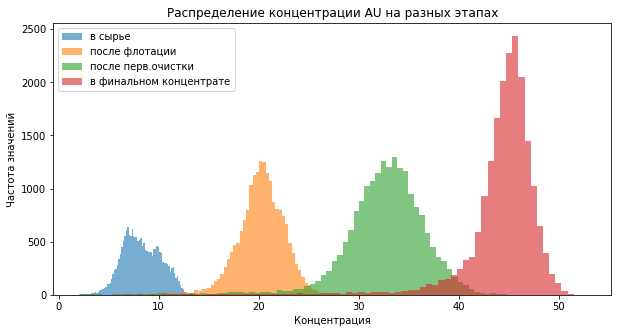

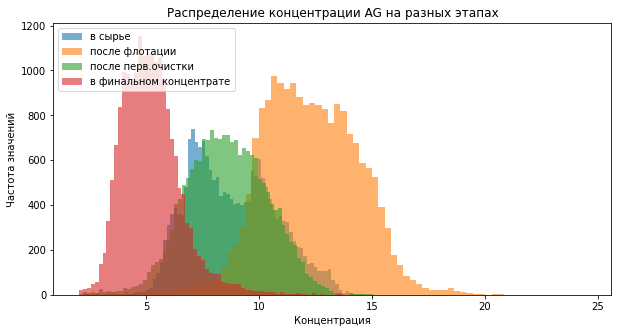

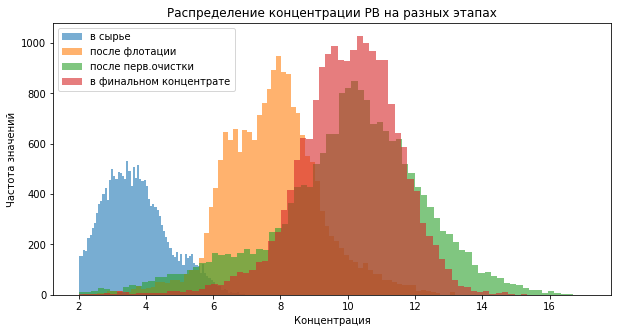

In [11]:
for idx in ['au', 'ag', 'pb']:
    plt.figure(figsize=(10, 5))
    plot1 = df_full[df_full['rougher.input.feed_' + idx] > 2
                   ]['rougher.input.feed_' + idx].plot(
        kind='hist', bins=80, label='в сырье', alpha=0.6)
    plot2 = df_full[df_full['rougher.output.concentrate_' + idx] > 2
                   ]['rougher.output.concentrate_' + idx].plot(
        kind='hist', bins=80, label='после флотации', alpha=0.6)
    plot3 = df_full[df_full['primary_cleaner.output.concentrate_' + idx] > 2
                   ]['primary_cleaner.output.concentrate_' + idx].plot(
        kind='hist', bins=80, label='после перв.очистки', alpha=0.6)
    plot4 = df_full[df_full['final.output.concentrate_' + idx] > 2
                   ]['final.output.concentrate_' + idx].plot(
        kind='hist', bins=80, label='в финальном концентрате', alpha=0.6)
    plt.xlabel('Концентрация')
    plt.ylabel('Частота значений')
    plt.legend(loc='upper left')
    plt.title('Распределение концентрации ' + idx.upper() + ' на разных этапах')
    plt.show()

Из полученных графиков видим, что концентрация золота с каждым этапом очистки растёт примерно на 10-15%, концентрация серебра падает примерно на 5-10%, а концентрация свинца после флотации возрастает на пару процентов, а затем остаётся примерно одинаковой.

Теперь взглянем на распределения размеров гранул сырья на обучающей и тестовой выборках, предварительно отбросив наименее вероятно встречающиеся случаи:

In [12]:
print(f'98%-ый доверительный интервал встречаемости гранул: ({df_train["rougher.input.feed_size"].quantile(0.01):.2f}, {df_train["rougher.input.feed_size"].quantile(0.99):.2f})')
print(f'98%-ый доверительный интервал встречаемости гранул: ({df_test["rougher.input.feed_size"].quantile(0.01):.2f}, {df_test["rougher.input.feed_size"].quantile(0.99):.2f})')

98%-ый доверительный интервал встречаемости гранул: (35.32, 127.61)
98%-ый доверительный интервал встречаемости гранул: (38.47, 111.93)


Построим график их распределения:

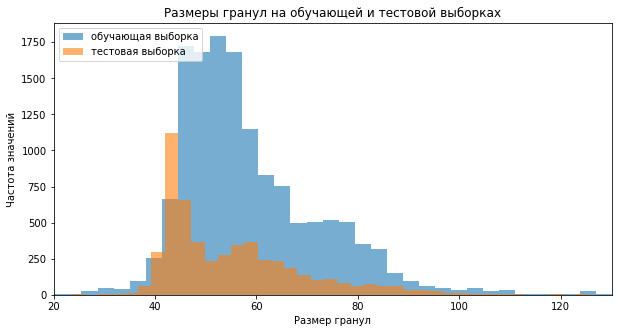

In [13]:
plt.figure(figsize=(10, 5))
plot1 = df_train['rougher.input.feed_size'].plot(
        kind='hist', bins=150, label='обучающая выборка', alpha=0.6)
plot2 = df_test['rougher.input.feed_size'].plot(
        kind='hist', bins=150, label='тестовая выборка', alpha=0.6)
plt.xlim(20, 130)
plt.xlabel('Размер гранул')
plt.ylabel('Частота значений')
plt.legend(loc='upper left')
plt.title('Размеры гранул на обучающей и тестовой выборках')
plt.show()

Видим, что распределения размеров гранул на обучающей и тестовой выборках не сильно отличаются друг от друга, поэтому оценка модели не будет неправильной.

Далее исследуем суммарную концентрацию всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах:

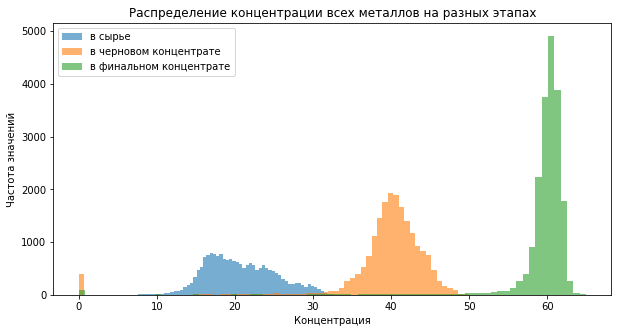

In [14]:
plt.figure(figsize=(10, 5))
plot1 = (df_full['rougher.input.feed_au'] + df_full['rougher.input.feed_ag'] +
         df_full['rougher.input.feed_pb']).plot(
        kind='hist', bins=80, label='в сырье', alpha=0.6)
plot2 = (df_full['rougher.output.concentrate_au'] +
         df_full['rougher.output.concentrate_ag'] +
         df_full['rougher.output.concentrate_pb']).plot(
        kind='hist', bins=80, label='в черновом концентрате', alpha=0.6)
plot3 = (df_full['final.output.concentrate_au'] + df_full['final.output.concentrate_ag'] +
         df_full['final.output.concentrate_pb']).plot(
        kind='hist', bins=80, label='в финальном концентрате', alpha=0.6)
#plt.xlim(25, 70)
plt.xlabel('Концентрация')
plt.ylabel('Частота значений')
plt.legend(loc='upper left')
plt.title('Распределение концентрации всех металлов на разных этапах')
plt.show()

Видим явную тенденцию к увеличению концентрации металлов с каждым этапом флотации и очистки. Также наблюдаем выбросы - это значения, близкие к нулю, похожие на явные ошибки измерений.

## Модель

Напишем функцию для вычисления итоговой sMAPE:

In [15]:
def sMAPE_calculate(predict, target):
    predict_rougher = predict['rougher.output.recovery']
    predict_final = predict['final.output.recovery']
    target_rougher = target[:,0]
    target_final = target[:,1]
    
    sMAPE_rougher = np.sum(abs(target_rougher - predict_rougher) / (
        (abs(target_rougher) + abs(predict_rougher)) / 2))
    sMAPE_rougher = sMAPE_rougher / len(target_rougher) * 100
       
    sMAPE_final = np.sum(abs(target_final - predict_final) / ((abs(target_final) + abs(predict_final)) / 2))
    sMAPE_final = sMAPE_final / len(target_final) * 100
    
    sMAPE = 0.25 * sMAPE_rougher + 0.75 * sMAPE_final
    return sMAPE

Далее сперва посмотрим на результаты работы модели линейной регрессии:

In [16]:
model = LinearRegression()
CVS=cross_val_score(model, features_train_st, target_train, cv=10,
                            scoring=make_scorer(sMAPE_calculate, greater_is_better=False))
print('sMAPE тестовой модели =', sum(abs(CVS)) / 10)

sMAPE тестовой модели = 11.526511765682077


Затем найдём наилучшие гиперпараметры для модели случайного леса, как для наиболее точной модели из всех изученных:

In [17]:
%%time

best_forest_model = None
best_forest_score = 1000
best_depth = 0
best_forest_est = 0
for est in tqdm(range(10, 51, 10)):
    for depth in range(3, 10):
        model = RandomForestRegressor(random_state=9428, n_estimators=est, max_depth=depth)
        CVS=cross_val_score(model, features_train_st, target_train, cv=5,
                            scoring=make_scorer(sMAPE_calculate, greater_is_better=False))
        final_CVS = sum(abs(CVS)) / 5
        if final_CVS < best_forest_score:
            best_forest_model = model
            best_forest_score = final_CVS
            best_depth = depth
            best_forest_est = est
print("Качество наилучшей модели:", best_forest_score, "Количество деревьев:", best_forest_est, "Глубина:", best_depth)

  0%|          | 0/5 [00:00<?, ?it/s]

Качество наилучшей модели: 10.29537204532305 Количество деревьев: 50 Глубина: 6
CPU times: user 20min, sys: 3.1 s, total: 20min 3s
Wall time: 20min 4s


Получили наилучшую модель, которую теперь можно проверить на тестовой выборке:

In [18]:
best_forest_model = RandomForestRegressor(random_state=9428, max_depth=6, n_estimators=20)
best_forest_model.fit(features_train_st, target_train)
predict_test = best_forest_model.predict(features_test_st)
predict_test = pd.DataFrame(predict_test, columns=['rougher.output.recovery','final.output.recovery'])
smape = sMAPE_calculate(predict_test, np.array(target_test))
print('sMAPE тестовой модели =', smape)

sMAPE тестовой модели = 9.346114433768593


Сравним полученные результаты с предсказанием константной модели:

In [19]:
dummy_model = DummyRegressor(strategy="mean")
dummy_model.fit(features_train_st, target_train)
dummy_predict = dummy_model.predict(features_test_st)
dummy_predict = pd.DataFrame(dummy_predict, columns=['rougher.output.recovery','final.output.recovery'])
smape = sMAPE_calculate(dummy_predict, np.array(target_test))
print('sMAPE константной модели =', smape)

sMAPE константной модели = 10.289630376021035


<b>Вывод: подготовили прототип наилучшей модели машинного обучения, которая предсказывает коэффициент восстановления золота из золотосодержащей руды со значением метрики sMAPE на тестовой выборке равной 9.346, что лучше предсказания константной модели примерно на 1%.</b>